# Exercise 1

Train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-08-19 08:06:25--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2023-08-19 08:06:26 (13.3 MB/s) - ‘names.txt’ saved [228145/228145]



In [ ]:
words = open('names.txt', 'r').read().splitlines()

In [ ]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [ ]:
import torch

Here is an overview of the process for creating a trigram language model based on the bigram single-layer language model we previously discussed.

1. **Data Preparation:**
    - Instead of bigrams, we will be creating trigrams (i.e., sequences of three characters) from the training data. We will have two input sequences `xs1` and `xs2` representing the first and second characters of each trigram, respectively. The output sequence `ys` will represent the third character of each trigram.

2. **Network Architecture:**
    - We will have two one-hot encoded input vectors for each trigram. Each vector will have a length of 27 (corresponding to the 26 characters in the alphabet plus the period character).
    - We will need a way to combine these two input vectors into a single input to the network. One approach is to concatenate the two vectors, resulting in a single input vector of length 54 (27+27) for each trigram.
    - The neural network will still be a single linear layer, but now it will have 54 input nodes (one for each element of the concatenated input vector) and 27 output nodes (one for each character).

3. **Forward Pass:**
    - We will compute the dot product between the concatenated input vector and the weight matrix `W`, which will now have dimensions 54x27.
    - We will compute the probabilities for the next character using the softmax function, as we did in the bigram model.

4. **Loss Function:**
    - The loss function will still be the negative log likelihood, which measures how well the predicted probabilities match the actual next character in each trigram.

5. **Backward Pass and Optimization:**
    - We will use gradient descent to optimize the weight matrix `W` based on the loss function.
    - We will compute the gradients of the loss function with respect to the weight matrix and update the weights accordingly.

6. **Regularization:**
    - As in the bigram model, we may use regularization to prevent overfitting. This is done by adding a term to the loss function that encourages the weights to stay close to zero.

The main difference between the trigram and bigram models lies in the data preparation and network architecture. In the trigram model, we need to handle two input characters (and hence two input vectors) for each example, while in the bigram model, we only had one input character (and one input vector) per example.

In terms of the shape of the tensors at each step:
- `xs1` and `xs2` will both have shape `(num_samples,)`.
- The one-hot encoded and concatenated input vectors will have shape `(num_samples, 54)`.
- The weight matrix `W` will have shape `(54, 27)`.
- The output logits and probabilities will have shape `(num_samples, 27)`.
- The output labels `ys` will have shape `(num_samples,)`.

The process for training and evaluating the trigram model will be similar to the bigram model, but we will be working with trigrams and a slightly different network architecture.

In [ ]:
# bigrams
xs, ys = [], []
for w in words[:1]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    print(ch1, ch2)
    xs.append(ix1)
    ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

. m
e m
m a
m .
number of examples:  4


In [ ]:
# create the dataset for trigrams
xs1, xs2, ys = [], [], []
for w in words[:1]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]
    print(ch1, ch2, ch3)
    xs1.append(ix1)
    xs2.append(ix2)
    ys.append(ix3)

xs1 = torch.tensor(xs1)
xs2 = torch.tensor(xs2)
ys = torch.tensor(ys)
num = ys.nelement()
print('number of examples: ', num)


. e m
e m m
m m a
m a .
number of examples:  4


In [ ]:
xs2

tensor([ 5, 13, 13,  1])

In [ ]:
# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((54, 27), generator=g, requires_grad=True) # Change: The weight matrix now has shape (54, 27)

In [ ]:
import torch.nn.functional as F

In [ ]:
a = torch.tensor([1,2])
b = torch.tensor([3,4])
c = torch.cat((a,b))
c

tensor([1, 2, 3, 4])

In [ ]:
xenc1 = F.one_hot(xs1, num_classes=27).float() # input to the network: one-hot encoding


In [ ]:
xenc1.shape

torch.Size([4, 27])

In [ ]:
xenc2 = F.one_hot(xs2, num_classes=27).float()

In [ ]:
xenc2.shape

torch.Size([4, 27])

In [ ]:
xenc = torch.cat((xenc1, xenc2),1)

In [ ]:
xenc.shape

torch.Size([4, 54])

In [ ]:
# create the dataset for trigrams
xs1, xs2, ys = [], [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]
    xs1.append(ix1)
    xs2.append(ix2)
    ys.append(ix3)

xs1 = torch.tensor(xs1)
xs2 = torch.tensor(xs2)
ys = torch.tensor(ys)
num = ys.nelement()
print('number of examples: ', num)

number of examples:  196113


In [ ]:

# gradient descent
for k in range(50):

    # forward pass
    xenc1 = F.one_hot(xs1, num_classes=27).float() # one-hot encoding for the first character
    xenc2 = F.one_hot(xs2, num_classes=27).float() # one-hot encoding for the second character
    xenc = torch.cat((xenc1, xenc2), dim=1) # Change: Concatenate the two one-hot encoded vectors
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
    loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
    print(loss.item())

    # backward pass
    W.grad = None # set to zero the gradient
    loss.backward()

    # update
    W.data += -50.0 * W.grad

2.5801351070404053
2.5415830612182617
2.5098514556884766
2.4840075969696045
2.463128089904785
2.4460954666137695
2.431868076324463
2.4196877479553223
2.40906023979187
2.399660110473633
2.3912625312805176
2.3837015628814697
2.3768529891967773
2.3706166744232178
2.364915370941162
2.3596839904785156
2.354867935180664
2.350421667098999
2.3463058471679688
2.342486619949341
2.3389341831207275
2.335622549057007
2.3325283527374268
2.329632520675659
2.326916217803955
2.324364423751831
2.321962833404541
2.3196990489959717
2.317561626434326
2.3155412673950195
2.3136277198791504
2.311814308166504
2.3100931644439697
2.3084568977355957
2.3069007396698
2.3054189682006836
2.3040056228637695
2.30265736579895
2.3013689517974854
2.300137758255005
2.298959493637085
2.297830820083618
2.2967493534088135
2.2957115173339844
2.294715404510498
2.2937583923339844
2.2928383350372314
2.2919528484344482
2.2911007404327393
2.2902798652648926


## Conclusion

Yes, it is expected that the trigram model would have a lower loss than the bigram model. This is because the trigram model takes into account more context (two previous characters) when predicting the next character, whereas the bigram model only considers one previous character. This additional context allows the trigram model to make more informed predictions, leading to a lower loss.

A seasoned ML practitioner would likely say that the improvement in loss is due to the increased context and information provided to the trigram model. They would also note that this pattern of improved performance with increased context is a general trend in language modeling. As models consider more context (n-grams, sentences, paragraphs, etc.), they typically become better at predicting the next word or character. However, there is a trade-off, as models with more context usually require more computational resources and may suffer from the curse of dimensionality.

In this specific case, the difference in loss is not huge, but it does indicate that the trigram model is better at predicting the next character than the bigram model. The seasoned practitioner might also consider other factors, such as the size of the dataset, the quality of the data, and the complexity of the model, when interpreting the difference in loss.

# Exercise 2
Split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

## A dev set is another name for a validation set.

A dev set is another name for a validation set. In machine learning, it's common to split the dataset into three parts: a training set, a validation (or dev) set, and a test set. The training set is used to train the model, the validation set is used to tune the model's hyperparameters and prevent overfitting, and the test set is used to evaluate the model's performance on unseen data.


## Training, Validation (or Development), and Test sets

When training a machine learning model, it's common to divide the data into three separate sets: training, validation (or development), and test sets. Each of these sets plays a distinct role in the model development process:

1. **Training set:** This set is used to train the model. The model learns to make predictions by adjusting its parameters based on the examples in this set.
2. **Validation (dev) set:** This set is used to tune the model's hyperparameters and make decisions about the model architecture. By evaluating the model on the validation set, you can see how well the model is generalizing to new, unseen data. However, you may make changes to the model or its training process based on the performance on this set, which can lead to overfitting to the validation set.
3. **Test set:** This set is used to assess the final performance of the model. It provides an unbiased estimate of how well the model is likely to perform on new, unseen data. You should only evaluate the model on the test set once, after all model development and tuning have been completed.

The distinction between the validation and test sets is crucial to avoid overfitting and ensure that you have an accurate measure of the model's performance on new data. If you use the test set to make decisions about the model during the development process, you risk overfitting to the test set, and your performance estimates will be overly optimistic.

In summary, you use the validation set to make decisions about the model during development, while you use the test set to assess the final performance of the model.

## Validation set
The need for a validation set arises from the desire to create a machine learning model that generalizes well to new, unseen data. When we train a model, we want to make sure it's not just memorizing the training data but learning patterns that can be applied to data it hasn't seen before. This is where the validation set comes in.

The validation set serves as a proxy for the test set, allowing us to simulate how the model would perform on new data without using the test set. The test set should be reserved for the final evaluation of the model and not used during the model development process.

Here's what a seasoned ML practitioner might say about the need for a validation set:

1. **Overfitting Detection**: The main role of the validation set is to detect overfitting. Overfitting occurs when a model becomes too complex and starts fitting the training data very closely, including the noise. As a result, it may perform poorly on new data. By comparing the training loss and validation loss, we can detect overfitting. If the training loss continues to decrease while the validation loss starts increasing, the model is likely overfitting.

2. **Hyperparameter Tuning**: The validation set is used to tune hyperparameters, which are parameters that are not learned during training but set beforehand. Examples include learning rate, regularization strength, and model architecture. By evaluating the model on the validation set, we can choose the best hyperparameters that lead to the best performance.

3. **Model Selection**: When comparing different models or model architectures, the validation set can be used to select the best model. The model that performs best on the validation set is likely to perform well on the test set.

4. **Early Stopping**: The validation set can be used to implement early stopping, a regularization technique where training is stopped once the validation loss stops improving or starts increasing. This helps prevent overfitting and can save computational resources.

5. **Adaptation to New Data**: In some cases, the validation set can be used to adapt the model to new data distributions. If the model's performance on the validation set degrades over time, it may indicate a shift in the data distribution, and the model can be retrained or adapted to the new data.

In summary, the validation set plays a crucial role in building robust machine learning models that generalize well to new data. It helps detect overfitting, tune hyperparameters, select models, implement early stopping, and adapt to new data distributions.

In [ ]:
# trigram - create the dataset
xs1, xs2, ys = [], [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        xs1.append(ix1)
        xs2.append(ix2)
        ys.append(ix3)



In [ ]:
len(ys)

196113

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.arange(10).reshape((5, 2))
y = range(5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train

array([[4, 5],
       [0, 1],
       [6, 7]])

In [ ]:
X = np.arange(10).reshape((5, 2))
X2 = np.arange(10).reshape((5, 2))
y = range(5)

X_train, X_test, X2_train, X2_test, y_train, y_test = train_test_split(X,X2, y, test_size=0.33, random_state=42)
X2_train

array([[4, 5],
       [0, 1],
       [6, 7]])

In [ ]:
# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((54, 27), generator=g, requires_grad=True) # Change: The weight matrix now has shape (54, 27)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Convert to numpy arrays
xs1 = np.array(xs1)
xs2 = np.array(xs2)
ys = np.array(ys)

# Split the dataset into 80% train, 10% validation, and 10% test
X1_train, X1_temp, X2_train, X2_temp, y_train, y_temp = train_test_split(xs1, xs2, ys, test_size=0.2, random_state=42)
X1_val, X1_test, X2_val, X2_test, y_val, y_test = train_test_split(X1_temp, X2_temp, y_temp, test_size=0.5, random_state=42)

# Convert back to PyTorch tensors
X1_train = torch.tensor(X1_train)
X2_train = torch.tensor(X2_train)
y_train = torch.tensor(y_train)
X1_val = torch.tensor(X1_val)
X2_val = torch.tensor(X2_val)
y_val = torch.tensor(y_val)
X1_test = torch.tensor(X1_test)
X2_test = torch.tensor(X2_test)
y_test = torch.tensor(y_test)


In [ ]:
# gradient descent

num = y_train.nelement()
num_val = y_val.nelement()

for k in range(50):

    # forward pass
    xenc1 = F.one_hot(X1_train, num_classes=27).float() # one-hot encoding for the first character
    xenc2 = F.one_hot(X2_train, num_classes=27).float() # one-hot encoding for the second character
    xenc = torch.cat((xenc1, xenc2), dim=1) # Change: Concatenate the two one-hot encoded vectors
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
    loss = -probs[torch.arange(num), y_train].log().mean() + 0.01*(W**2).mean()
    print(f"Epoch {k+1}, Training Loss: {loss.item()}")

    # Forward pass (validation)
    xenc_val1 = F.one_hot(X1_val, num_classes=27).float() # one-hot encoding for the first character
    xenc_val2 = F.one_hot(X2_val, num_classes=27).float() # one-hot encoding for the second character
    xenc_val = torch.cat((xenc_val1, xenc_val2), dim=1) # Change: Concatenate the two one-hot encoded vectors
    logits_val = xenc_val @ W # predict log-counts
    counts_val = logits_val.exp() # counts, equivalent to N
    probs_val = counts_val / counts_val.sum(1, keepdims=True) # probabilities for next character
    loss_val = -probs_val[torch.arange(num_val), y_val].log().mean() + 0.01*(W**2).mean()
    print(f"Epoch {k+1}, Validation Loss: {loss_val.item()}")

    # backward pass
    W.grad = None # set to zero the gradient
    loss.backward()

    # update
    W.data += -50.0 * W.grad

Epoch 1, Training Loss: 4.195179462432861
Epoch 1, Validation Loss: 4.2056193351745605
Epoch 2, Training Loss: 3.3654816150665283
Epoch 2, Validation Loss: 3.377584218978882
Epoch 3, Training Loss: 3.0503995418548584
Epoch 3, Validation Loss: 3.060450792312622
Epoch 4, Training Loss: 2.8794777393341064
Epoch 4, Validation Loss: 2.8844852447509766
Epoch 5, Training Loss: 2.7748968601226807
Epoch 5, Validation Loss: 2.778290271759033
Epoch 6, Training Loss: 2.702197313308716
Epoch 6, Validation Loss: 2.7031898498535156
Epoch 7, Training Loss: 2.6465039253234863
Epoch 7, Validation Loss: 2.646820306777954
Epoch 8, Training Loss: 2.6023285388946533
Epoch 8, Validation Loss: 2.6012966632843018
Epoch 9, Training Loss: 2.566324234008789
Epoch 9, Validation Loss: 2.564929485321045
Epoch 10, Training Loss: 2.5365397930145264
Epoch 10, Validation Loss: 2.5342533588409424
Epoch 11, Training Loss: 2.511561870574951
Epoch 11, Validation Loss: 2.509014368057251
Epoch 12, Training Loss: 2.49041390419

## Interpreting these results

The results show the training and validation loss over 50 epochs of training. A seasoned ML practitioner would interpret these results as follows:

1. **Loss Decreasing**: Both the training and validation losses are decreasing over time, indicating that the model is learning from the data and improving its performance. This is a good sign.

2. **No Overfitting**: The validation loss follows the training loss closely, which means the model is generalizing well to the validation set. If the validation loss started to increase while the training loss continued to decrease, it would be a sign of overfitting. In this case, there is no sign of overfitting.

3. **Convergence**: The loss values seem to be converging, meaning that they are reaching a stable value and not changing significantly with more training. This suggests that the model has learned most of what it can from the data and further training might not bring significant improvements.

4. **Hyperparameter Tuning**: Since there's no sign of overfitting, there might not be an immediate need for hyperparameter tuning. However, it could still be beneficial to experiment with different hyperparameters (e.g., learning rate, regularization strength, etc.) to see if it's possible to achieve even better performance.

5. **Next Steps**: Since the model seems to be performing well, a natural next step would be to evaluate it on the test set to get an estimate of its performance on unseen data. Additionally, more advanced models or features could be explored to see if they can further improve performance.

Overall, these results indicate that the model has been successfully trained, is generalizing well to the validation data, and is likely ready for evaluation on the test set. The absence of overfitting and the convergence of the loss values are positive signs.

Regarding the difference in loss between the training and validation sets, it's normal to observe slight differences because the two sets are made up of different data samples. The important thing is that the validation loss follows the training loss closely, which indicates good generalization. If the model were overfitting to the training data, you would observe a significant divergence between the two loss curves.

## The Test set

Unlike the training phase, where we perform multiple iterations (epochs) to update the model's parameters, during evaluation we only need to pass the test data through the model once to compute the loss or any other performance metrics. There is no need for multiple iterations or parameter updates during evaluation.

The idea is to assess how well the model, which was trained on the training data, generalizes to unseen data. We use the test set, which the model has never seen before, to get an unbiased estimate of the model's performance. This allows us to make informed decisions about the model's quality and suitability for deployment or further refinement.

## Evaluating the model on the Test set
To evaluate the model on the test set, follow these steps:

1. **Forward Pass**: Pass the test data through the model (perform a forward pass) to get the predicted outputs. Make sure not to include the gradients computation or the backward pass, as you are not training the model at this stage. You can use the `torch.no_grad()` context manager to ensure that no gradients are computed.

2. **Compute the Loss**: Compute the loss on the test set using the predicted outputs and the actual targets. This will give you an idea of how well the model performs on unseen data.

3. **Compute Performance Metrics**: Depending on the task, compute relevant performance metrics on the test set. For example, in a classification task, you may compute accuracy, precision, recall, F1-score, etc. For a regression task, you may compute the mean squared error, mean absolute error, R-squared, etc.

4. **Compare with Validation Performance**: Compare the performance on the test set with that on the validation set. This will help you assess the model's generalization ability.

5. **Interpret the Results**: Analyze the results, including any discrepancies between training, validation, and test performances. Consider whether the model is overfitting, underfitting, or generalizing well.

6. **Report the Results**: Document the test results, including the loss and performance metrics, and any insights you have gained from the evaluation.

7. **Model Analysis**: Optionally, you can further analyze the model's predictions. For example, you can visualize the model's predictions vs. actual values, analyze errors made by the model, or identify patterns in the data where the model performs well or poorly.

Remember that once you evaluate the model on the test set, you should not tune the model further based on the test results. The test set is meant to provide an unbiased estimate of the model's performance on unseen data. If you tune the model based on test results, you risk overfitting to the test set and losing the ability to generalize to new, unseen data.

In [ ]:
# We have already split the data into train, dev, and test sets
# The trained model is stored in the variable W

test_num = X1_test.nelement()

# Forward pass (without gradients computation)
with torch.no_grad():
    xenc1_test = F.one_hot(X1_test, num_classes=27).float()
    xenc2_test = F.one_hot(X2_test, num_classes=27).float()
    xenc_test = torch.cat((xenc1_test, xenc1_test), dim=1)
    logits_test = xenc_test @ W # predict log-counts on test data
    counts_test = logits_test.exp() # counts, equivalent to N
    probs_test = counts_test / counts_test.sum(1, keepdims=True) # probabilities for next character
    loss_test = -probs_test[torch.arange(test_num), y_test].log().mean() + 0.01*(W**2).mean() # compute the loss on test data

print("Test Loss:", loss_test.item())


Test Loss: 3.149600028991699


## Interpreting these results

A seasoned ML practitioner would interpret these results as follows:

1. **Training Loss**: The training loss has reduced over the course of 50 epochs, indicating that the model has been learning and improving its performance on the training dataset. However, the training loss could be further reduced by increasing the number of epochs, changing the optimization algorithm, or tuning the hyperparameters.

2. **Validation Loss**: The validation loss, which is quite close to the training loss, indicates that the model is generalizing well to new data from the same distribution as the training set. This is a good sign, as it suggests that the model is not overfitting.

3. **Test Loss**: The test loss is higher than both the training and validation losses, indicating that the model may not be performing as well on the test set as it did on the training and validation sets. This could be due to a variety of factors, such as differences in the distribution of the test set compared to the training and validation sets, or due to the model not being complex enough to capture the underlying patterns in the test set.

Based on these observations, the ML practitioner could consider the following steps:

1. **Evaluate Other Metrics**: In addition to the loss, it is important to evaluate the model using other metrics that are relevant to the task at hand, such as accuracy, precision, recall, or F1 score. This will provide a more comprehensive view of the model's performance.

2. **Investigate the Test Set**: It is important to analyze the test set to understand why the model's performance may be lower on it compared to the training and validation sets. This could involve checking for class imbalance, outliers, or differences in the distribution of features.

3. **Model Complexity**: The practitioner could experiment with a more complex model architecture, such as adding more layers or neurons, to see if it helps improve performance on the test set.

4. **Hyperparameter Tuning**: The practitioner could conduct a hyperparameter search to find the optimal set of hyperparameters that yield the best performance on the validation set. This could involve tuning the learning rate, regularization strength, batch size, and other hyperparameters.

5. **Regularization and Augmentation**: If overfitting is suspected, the practitioner could apply regularization techniques (e.g., dropout or L1/L2 regularization) or use data augmentation to increase the diversity of the training data.

6. **Early Stopping**: If the validation loss starts to increase while the training loss continues to decrease, the practitioner could implement early stopping to prevent overfitting.

It is essential to iteratively experiment with different approaches and carefully evaluate the results to improve the model's performance on the test set.

In [ ]:
# initialize the 'network' with different seed
g = torch.Generator().manual_seed(2147483647 + 1)
W = torch.randn((54, 27), generator=g, requires_grad=True) # Change: The weight matrix now has shape (54, 27)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Convert to numpy arrays
xs1 = np.array(xs1)
xs2 = np.array(xs2)
ys = np.array(ys)

# Split the dataset into 80% train, 10% validation, and 10% test
X1_train, X1_temp, X2_train, X2_temp, y_train, y_temp = train_test_split(xs1, xs2, ys, test_size=0.2, random_state=42)
X1_val, X1_test, X2_val, X2_test, y_val, y_test = train_test_split(X1_temp, X2_temp, y_temp, test_size=0.5, random_state=42)

# Convert back to PyTorch tensors
X1_train = torch.tensor(X1_train)
X2_train = torch.tensor(X2_train)
y_train = torch.tensor(y_train)
X1_val = torch.tensor(X1_val)
X2_val = torch.tensor(X2_val)
y_val = torch.tensor(y_val)
X1_test = torch.tensor(X1_test)
X2_test = torch.tensor(X2_test)
y_test = torch.tensor(y_test)

In [ ]:
# gradient descent

num = y_train.nelement()
num_val = y_val.nelement()

for k in range(50):

    # forward pass
    xenc1 = F.one_hot(X1_train, num_classes=27).float() # one-hot encoding for the first character
    xenc2 = F.one_hot(X2_train, num_classes=27).float() # one-hot encoding for the second character
    xenc = torch.cat((xenc1, xenc2), dim=1) # Change: Concatenate the two one-hot encoded vectors
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
    loss = -probs[torch.arange(num), y_train].log().mean() + 0.01*(W**2).mean()
    print(f"Epoch {k+1}, Training Loss: {loss.item()}")

    # Forward pass (validation)
    xenc_val1 = F.one_hot(X1_val, num_classes=27).float() # one-hot encoding for the first character
    xenc_val2 = F.one_hot(X2_val, num_classes=27).float() # one-hot encoding for the second character
    xenc_val = torch.cat((xenc_val1, xenc_val2), dim=1) # Change: Concatenate the two one-hot encoded vectors
    logits_val = xenc_val @ W # predict log-counts
    counts_val = logits_val.exp() # counts, equivalent to N
    probs_val = counts_val / counts_val.sum(1, keepdims=True) # probabilities for next character
    loss_val = -probs_val[torch.arange(num_val), y_val].log().mean() + 0.01*(W**2).mean()
    print(f"Epoch {k+1}, Validation Loss: {loss_val.item()}")

    # backward pass
    W.grad = None # set to zero the gradient
    loss.backward()

    # update
    W.data += -50.0 * W.grad

Epoch 1, Training Loss: 4.031497001647949
Epoch 1, Validation Loss: 4.0244526863098145
Epoch 2, Training Loss: 3.349173069000244
Epoch 2, Validation Loss: 3.3432114124298096
Epoch 3, Training Loss: 3.0437161922454834
Epoch 3, Validation Loss: 3.0348005294799805
Epoch 4, Training Loss: 2.8713440895080566
Epoch 4, Validation Loss: 2.860811948776245
Epoch 5, Training Loss: 2.7608463764190674
Epoch 5, Validation Loss: 2.7489452362060547
Epoch 6, Training Loss: 2.6846230030059814
Epoch 6, Validation Loss: 2.6728975772857666
Epoch 7, Training Loss: 2.6293413639068604
Epoch 7, Validation Loss: 2.617408037185669
Epoch 8, Training Loss: 2.587205171585083
Epoch 8, Validation Loss: 2.575857639312744
Epoch 9, Training Loss: 2.553819179534912
Epoch 9, Validation Loss: 2.542658567428589
Epoch 10, Training Loss: 2.5265302658081055
Epoch 10, Validation Loss: 2.5159969329833984
Epoch 11, Training Loss: 2.5037059783935547
Epoch 11, Validation Loss: 2.49346923828125
Epoch 12, Training Loss: 2.48428010940

In [ ]:
# We have already split the data into train, dev, and test sets
# The trained model is stored in the variable W

test_num = X1_test.nelement()

# Forward pass (without gradients computation)
with torch.no_grad():
    xenc1_test = F.one_hot(X1_test, num_classes=27).float()
    xenc2_test = F.one_hot(X2_test, num_classes=27).float()
    xenc_test = torch.cat((xenc1_test, xenc2_test), dim=1) # typo was here!!!!!
    logits_test = xenc_test @ W # predict log-counts on test data
    counts_test = logits_test.exp() # counts, equivalent to N
    probs_test = counts_test / counts_test.sum(1, keepdims=True) # probabilities for next character
    loss_test = -probs_test[torch.arange(test_num), y_test].log().mean() + 0.01*(W**2).mean() # compute the loss on test data

print("Test Loss:", loss_test.item())

Test Loss: 2.3037922382354736



# Exercise 3:

Use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?


## Tune the Strength of Smoothing or Regularization

Follow these steps:

1. **Tune the Strength of Smoothing or Regularization**:
    - Define a range of values for the regularization strength (or smoothing strength). You can use a logarithmic scale, for example, \([0.0001, 0.001, 0.01, 0.1, 1, 10]\).
    - For each value in the range, train the trigram model on the training set, applying the chosen regularization strength.
    - Evaluate the model on the dev set (validation set) and record the loss for each value of the regularization strength.
    - Plot the training and dev set losses as a function of the regularization strength to visualize the patterns.

2. **Observe Patterns**:
    - Look for patterns in the plot. Typically, as the regularization strength increases, the training loss may increase (due to the model being constrained), while the dev set loss may first decrease (as it prevents overfitting) and then increase (due to underfitting).
    - Identify the value of the regularization strength that gives the lowest dev set loss. This is the optimal value that balances the bias-variance trade-off.

3. **Evaluate on the Test Set**:
    - Once you have identified the best regularization strength, retrain the trigram model on the entire training set using this value.
    - Evaluate the model on the test set and report the loss. This will give you an unbiased estimate of the model's performance on unseen data.

4. **Report the Loss**:
    - Report the test set loss achieved with the best setting of the regularization strength. Compare it with the losses achieved without tuning the regularization strength.

Remember that the goal of tuning the regularization strength is to find a balance between fitting the training data well and generalizing to new, unseen data.

In [ ]:
g = torch.Generator().manual_seed(2147483647)

In [ ]:

regularization_strengths = [0.0000001, 0.000001, 0.00001, 0.00005, 0.0001, 0.001, 0.01, 0.1, 1, 10]
train_losses = []
dev_losses = []

for reg_strength in regularization_strengths:
    # Re-initialize the model with the new regularization strength
    W = torch.randn((54, 27), generator=g, requires_grad=True) # Change: The weight matrix now has shape (54, 27)

    # Train the model on the training set
    for k in range(50):
      # forward pass
      xenc1 = F.one_hot(X1_train, num_classes=27).float()
      xenc2 = F.one_hot(X2_train, num_classes=27).float()
      xenc = torch.cat((xenc1, xenc2), dim=1)
      logits = xenc @ W
      counts = logits.exp()
      probs = counts / counts.sum(1, keepdims=True)
      loss = -probs[torch.arange(num), y_train].log().mean() + reg_strength * (W**2).mean()
      # print(f"Epoch {k+1}, Training Loss: {loss.item()}")

      # backward pass
      W.grad = None
      loss.backward()

      # update
      W.data += -50.0 * W.grad


    # Evaluate the model on the dev set
    xenc_val1 = F.one_hot(X1_val, num_classes=27).float()
    xenc_val2 = F.one_hot(X2_val, num_classes=27).float()
    xenc_val = torch.cat((xenc_val1, xenc_val2), dim=1)
    logits_val = xenc_val @ W
    counts_val = logits_val.exp()
    probs_val = counts_val / counts_val.sum(1, keepdims=True)
    loss_val = -probs_val[torch.arange(num_val), y_val].log().mean() + reg_strength * (W**2).mean()
    print(f"Epoch {k+1}, Validation Loss: {loss_val.item()}")

    # Record the losses
    train_losses.append(loss.item())
    dev_losses.append(loss_val.item())


Epoch 50, Validation Loss: 2.287224292755127
Epoch 50, Validation Loss: 2.289905071258545
Epoch 50, Validation Loss: 2.2870969772338867
Epoch 50, Validation Loss: 2.290210008621216
Epoch 50, Validation Loss: 2.285079002380371
Epoch 50, Validation Loss: 2.2852158546447754
Epoch 50, Validation Loss: 2.293046712875366
Epoch 50, Validation Loss: 2.3439362049102783
Epoch 50, Validation Loss: 2.542637825012207
Epoch 50, Validation Loss: 2.988537073135376


In [ ]:
train_losses

[2.2952938079833984,
 2.296586751937866,
 2.2926440238952637,
 2.296921730041504,
 2.2944579124450684,
 2.294264316558838,
 2.300032615661621,
 2.3512258529663086,
 2.5461947917938232,
 2.9872498512268066]

In [ ]:
dev_losses

[2.287224292755127,
 2.289905071258545,
 2.2870969772338867,
 2.290210008621216,
 2.285079002380371,
 2.2852158546447754,
 2.293046712875366,
 2.3439362049102783,
 2.542637825012207,
 2.988537073135376]

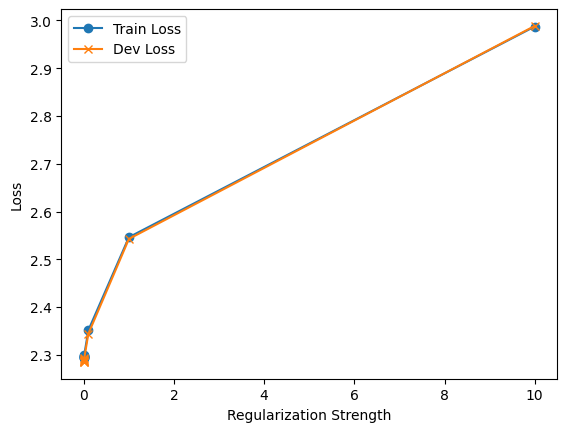

In [ ]:
# Plot the losses as a function of the regularization strength

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(regularization_strengths, train_losses, label='Train Loss', marker='o')
plt.plot(regularization_strengths, dev_losses, label='Dev Loss', marker='x')
plt.xlabel('Regularization Strength')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [ ]:


# Identify the best regularization strength
best_reg_strength = regularization_strengths[np.argmin(dev_losses)]
best_reg_strength

0.0001

In [ ]:
# retrain with optimum regularization strength
g = torch.Generator().manual_seed(2147483647 + 1)
W = torch.randn((54, 27), generator=g, requires_grad=True)

In [ ]:


num = y_train.nelement()
num_val = y_val.nelement()

for k in range(50):

    # forward pass
    xenc1 = F.one_hot(X1_train, num_classes=27).float() # one-hot encoding for the first character
    xenc2 = F.one_hot(X2_train, num_classes=27).float() # one-hot encoding for the second character
    xenc = torch.cat((xenc1, xenc2), dim=1) # Change: Concatenate the two one-hot encoded vectors
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
    loss = -probs[torch.arange(num), y_train].log().mean() + best_reg_strength*(W**2).mean()
    print(f"Epoch {k+1}, Training Loss: {loss.item()}")

    # Forward pass (validation)
    xenc_val1 = F.one_hot(X1_val, num_classes=27).float() # one-hot encoding for the first character
    xenc_val2 = F.one_hot(X2_val, num_classes=27).float() # one-hot encoding for the second character
    xenc_val = torch.cat((xenc_val1, xenc_val2), dim=1) # Change: Concatenate the two one-hot encoded vectors
    logits_val = xenc_val @ W # predict log-counts
    counts_val = logits_val.exp() # counts, equivalent to N
    probs_val = counts_val / counts_val.sum(1, keepdims=True) # probabilities for next character
    loss_val = -probs_val[torch.arange(num_val), y_val].log().mean() + best_reg_strength*(W**2).mean()
    print(f"Epoch {k+1}, Validation Loss: {loss_val.item()}")

    # backward pass
    W.grad = None # set to zero the gradient
    loss.backward()

    # update
    W.data += -50.0 * W.grad

Epoch 1, Training Loss: 4.0216522216796875
Epoch 1, Validation Loss: 4.014607906341553
Epoch 2, Training Loss: 3.3409671783447266
Epoch 2, Validation Loss: 3.3350014686584473
Epoch 3, Training Loss: 3.036214590072632
Epoch 3, Validation Loss: 3.0272939205169678
Epoch 4, Training Loss: 2.8642473220825195
Epoch 4, Validation Loss: 2.8536946773529053
Epoch 5, Training Loss: 2.7539925575256348
Epoch 5, Validation Loss: 2.7420620918273926
Epoch 6, Training Loss: 2.6779322624206543
Epoch 6, Validation Loss: 2.666165351867676
Epoch 7, Training Loss: 2.622770071029663
Epoch 7, Validation Loss: 2.6107897758483887
Epoch 8, Training Loss: 2.5807249546051025
Epoch 8, Validation Loss: 2.5693233013153076
Epoch 9, Training Loss: 2.5474092960357666
Epoch 9, Validation Loss: 2.5361921787261963
Epoch 10, Training Loss: 2.5201735496520996
Epoch 10, Validation Loss: 2.509579658508301
Epoch 11, Training Loss: 2.4973881244659424
Epoch 11, Validation Loss: 2.4870896339416504
Epoch 12, Training Loss: 2.477988

In [ ]:
# Evaluate on the Test Set:

test_num = X1_test.nelement()

# Forward pass (without gradients computation)
with torch.no_grad():
    xenc1_test = F.one_hot(X1_test, num_classes=27).float()
    xenc2_test = F.one_hot(X2_test, num_classes=27).float()
    xenc_test = torch.cat((xenc1_test, xenc2_test), dim=1) # typo was here!!!!!
    logits_test = xenc_test @ W # predict log-counts on test data
    counts_test = logits_test.exp() # counts, equivalent to N
    probs_test = counts_test / counts_test.sum(1, keepdims=True) # probabilities for next character
    loss_test = -probs_test[torch.arange(test_num), y_test].log().mean() + best_reg_strength*(W**2).mean() # compute the loss on test data

print("Test Loss:", loss_test.item())

Test Loss: 2.2965903282165527


## Summary

A seasoned machine learning practitioner would likely conclude the following:

1. **Regularization Helped**: The improved test loss after tuning the regularization strength indicates that regularization helped prevent overfitting on the training data and improved generalization to new, unseen data.

2. **Good Model Generalization**: The similar performance on the training, dev, and test sets suggests that the model has learned patterns that are generalizable across different data splits. This is a good sign of a well-trained model.

3. **Further Improvements**: While the model has improved with regularization, it is always worth considering other ways to further enhance the model. This could include experimenting with different model architectures, adding more data, or exploring additional features.

4. **Interpret Results**: The practitioner might also want to interpret the results in the context of the problem domain. Is the improvement in test loss significant enough to make a difference in the practical application of the model? The answer to this question can help determine the next steps in the model development process.

5. **Model Deployment**: If the model has reached a satisfactory level of performance, it may be time to consider deploying it in a real-world setting. This involves integrating the model into a production environment and monitoring its performance over time.

In summary, the decrease in test loss after optimizing the regularization strength indicates a successful regularization process, which helped the model generalize better to new data. Further model improvements can be explored, and the results should be interpreted in the context of the specific problem domain.

# Exercise 4:

(this was tricky to get working)

We saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?


## Replacing the one-hot encoding

You can replace the one-hot encoding with direct indexing into the weight matrix \( W \).

1. Instead of using one-hot encoding for \( X1 \) and \( X2 \), use the indices directly to index into the weight matrix \( W \).
2. Concatenate the rows you've selected from \( W \) along the second dimension.


This approach is more efficient because it avoids the unnecessary step of creating one-hot encoded vectors, which can be memory-intensive and computationally expensive. Instead, we directly use the indices to select the relevant rows from the weight matrix \( W \).



Let's assume we have a vocabulary of only 3 characters: "a", "b", and "c". We want to create a bigram model, so our weight matrix \(W\) will have a shape of (3, 3). Let's initialize it with the following values:

$$
W = \begin{pmatrix}
0.1 & 0.2 & 0.3 \\
0.4 & 0.5 & 0.6 \\
0.7 & 0.8 & 0.9
\end{pmatrix}
$$

Now, let's consider a simple input sequence "abc". We want to predict the next character for each character in the sequence. We'll use the one-hot encoding approach and the direct indexing approach to calculate the logits for each character.

1. One-hot encoding approach:

$$
\text{For character "a"}: \text{one-hot} = [1, 0, 0], \text{logits} = [1, 0, 0] \times W = [0.1, 0.2, 0.3]
$$

$$
\text{For character "b"}: \text{one-hot} = [0, 1, 0], \text{logits} = [0, 1, 0] \times W = [0.4, 0.5, 0.6]
$$

$$
\text{For character "c"}: \text{one-hot} = [0, 0, 1], \text{logits} = [0, 0, 1] \times W = [0.7, 0.8, 0.9]
$$

2. Direct indexing approach:

$$
\text{For character "a"}: \text{index} = 0, \text{logits} = W[0] = [0.1, 0.2, 0.3]
$$

$$
\text{For character "b"}: \text{index} = 1, \text{logits} = W[1] = [0.4, 0.5, 0.6]
$$

$$
\text{For character "c"}: \text{index} = 2, \text{logits} = W[2] = [0.7, 0.8, 0.9]
$$


In [ ]:
import torch
import torch.nn.functional as F

# Define the small W matrix
W = torch.tensor([[0.1, 0.2, 0.3],
                  [0.4, 0.5, 0.6],
                  [0.7, 0.8, 0.9]], requires_grad=True)

# Define the input sequence
input_seq = "abc"
stoi = {'a': 0, 'b': 1, 'c': 2}
X1_train = torch.tensor([stoi[c] for c in input_seq])

# One-hot encoding approach
xenc1 = F.one_hot(X1_train, num_classes=3).float()
logits_one_hot = xenc1 @ W
loss_one_hot = -torch.log(logits_one_hot.exp() / logits_one_hot.exp().sum(1, keepdims=True)).mean()
print("Loss using one-hot encoding:", loss_one_hot.item())

# Direct indexing approach
logits_index = W[X1_train]
loss_index = -torch.log(logits_index.exp() / logits_index.exp().sum(1, keepdims=True)).mean()
print("Loss using direct indexing:", loss_index.item())

Loss using one-hot encoding: 1.101942777633667
Loss using direct indexing: 1.101942777633667


In [ ]:
import torch
import torch.nn.functional as F

# Define the small W matrix
W = torch.tensor([[0.1, 0.2, 0.3],
                  [0.4, 0.5, 0.6],
                  [0.7, 0.8, 0.9]], requires_grad=True)

# Define the input sequence
input_seq = "abc"
stoi = {'a': 0, 'b': 1, 'c': 2}
X1_train = torch.tensor([stoi[c] for c in input_seq])
X2_train = torch.roll(X1_train, -1)

# One-hot encoding approach
xenc1 = F.one_hot(X1_train, num_classes=3).float()
xenc2 = F.one_hot(X2_train, num_classes=3).float()
logits_one_hot1 = xenc1 @ W
logits_one_hot2 = xenc2 @ W
loss_one_hot = (-torch.log(logits_one_hot1.exp() / logits_one_hot1.exp().sum(1, keepdims=True)).mean()
                -torch.log(logits_one_hot2.exp() / logits_one_hot2.exp().sum(1, keepdims=True)).mean()) / 2
print("Loss using one-hot encoding:", loss_one_hot.item())

# Direct indexing approach
logits_index1 = W[X1_train]
logits_index2 = W[X2_train]
loss_index = (-torch.log(logits_index1.exp() / logits_index1.exp().sum(1, keepdims=True)).mean()
              -torch.log(logits_index2.exp() / logits_index2.exp().sum(1, keepdims=True)).mean()) / 2
print("Loss using direct indexing:", loss_index.item())


Loss using one-hot encoding: 1.101942777633667
Loss using direct indexing: 1.101942777633667


In [ ]:
torch.equal(logits_one_hot1, logits_index1)

True

In [ ]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [ ]:
# create the dataset for trigrams
xs1, xs2, ys = [], [], []
for w in words[:1]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]
    print(ch1, ch2, ch3)
    xs1.append(ix1)
    xs2.append(ix2)
    ys.append(ix3)

xs1 = torch.tensor(xs1)
xs2 = torch.tensor(xs2)
ys = torch.tensor(ys)
num = ys.nelement()
print('number of examples: ', num)

. e m
e m m
m m a
m a .
number of examples:  4


In [ ]:
g = torch.Generator().manual_seed(2147483647 + 1)
W = torch.randn((54, 27), generator=g, requires_grad=True)

In [ ]:
xenc1 = F.one_hot(xs1, num_classes=27).float() # one-hot encoding for the first character

In [ ]:
xs1

tensor([ 0,  5, 13, 13])

In [ ]:
xenc1

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
xs1

tensor([ 0,  5, 13, 13])

In [ ]:
xs2

tensor([ 5, 13, 13,  1])

In [ ]:
# much experimentation follows.

xenc1 = F.one_hot(xs1, num_classes=27).float()
xenc2 = F.one_hot(xs2, num_classes=27).float()
xenc = torch.cat((xenc1, xenc2), dim=1)
logits = xenc @ W
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
print(loss.item())

5.173408508300781


In [ ]:
wenc1 = W[xs1]
wenc2 = W[xs2]
wenc = torch.cat((wenc1, wenc2), dim=1)
logits = wenc
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
print(loss.item())

4.482119560241699


In [ ]:
# One-hot encoding approach
xenc1 = F.one_hot(xs1, num_classes=27).float()
xenc2 = F.one_hot(xs2, num_classes=27).float()
xenc = torch.cat((xenc1, xenc2), dim=1)
logits = xenc @ W
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
print(loss.item())

# Direct indexing approach
wenc1 = W[xs1]
wenc2 = W[xs2]
wenc = torch.cat((wenc1, wenc2), dim=1)
logits = wenc  # Use the indexed values directly as logits
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
print(loss.item())


5.173408508300781
4.482119560241699


In [ ]:
# One-hot encoding approach
xenc1 = F.one_hot(xs1, num_classes=27).float()
xenc2 = F.one_hot(xs2, num_classes=27).float()
xenc = torch.cat((xenc1, xenc2), dim=1)
logits = xenc @ W
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
print(loss.item())

# Direct indexing approach
wenc1 = W[xs1]
wenc2 = W[xs2]
wenc = torch.cat((wenc1, wenc2), dim=1)
logits_d = wenc # Use the indexed values directly as logits
counts_d = logits_d.exp()
probs_d = counts_d / counts_d.sum(1, keepdims=True)
loss_d = -probs_d[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
print(loss_d.item())

5.173408508300781
4.1515631675720215


In [ ]:
torch.equal(xenc1, wenc1)

False

In [ ]:
xenc1.shape

torch.Size([4, 27])

In [ ]:
wenc1.shape

torch.Size([4, 27])

In [ ]:
wenc.shape

torch.Size([4, 54])

In [ ]:
# One-hot encoding approach
xenc1 = F.one_hot(xs1, num_classes=27).float()
xenc2 = F.one_hot(xs2, num_classes=27).float()
logits1 = xenc1 @ W[:27]
logits2 = xenc2 @ W[:27]
logits = torch.cat((logits1, logits2), dim=1)
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
print(loss.item())

# Direct indexing approach
wenc1 = W[xs1]
wenc2 = W[xs2]
wenc = torch.cat((wenc1, wenc2), dim=1)
logits = wenc  # Use the indexed values directly as logits
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
print(loss.item())


4.482119560241699
4.482119560241699


In [ ]:
import torch
import torch.nn.functional as F

# Define the small W matrix
W = torch.tensor([[0.1, 0.2, 0.3],
                  [0.4, 0.5, 0.6],
                  [0.7, 0.8, 0.9]], requires_grad=True)

# Define the input sequence
input_seq = "abc"
stoi = {'a': 0, 'b': 1, 'c': 2}
X1_train = torch.tensor([stoi[c] for c in input_seq])
X2_train = torch.roll(X1_train, -1)

# One-hot encoding approach
xenc1 = F.one_hot(X1_train, num_classes=3).float()
xenc2 = F.one_hot(X2_train, num_classes=3).float()
xenc = torch.cat((xenc1, xenc2), dim=1)
logits_one_hot = xenc @ torch.cat((W, W), dim=0)
loss_one_hot = -torch.log(logits_one_hot.exp() / logits_one_hot.exp().sum(1, keepdims=True)).mean()
print("Loss using one-hot encoding:", loss_one_hot.item())

# Direct indexing approach
wenc1 = W[X1_train]
wenc2 = W[X2_train]
wenc = torch.cat((wenc1, wenc2), dim=1)
logits_index = wenc  # Use the indexed values directly as logits
loss_index = -torch.log(logits_index.exp() / logits_index.exp().sum(1, keepdims=True)).mean()
print("Loss using direct indexing:", loss_index.item())


Loss using one-hot encoding: 1.1119014024734497
Loss using direct indexing: 1.8173422813415527


In [ ]:
import torch
import torch.nn.functional as F

# Define the small W matrix
W = torch.tensor([[0.1, 0.2, 0.3],
                  [0.4, 0.5, 0.6],
                  [0.7, 0.8, 0.9]], requires_grad=True)

# Define the input sequence
input_seq = "abc"
stoi = {'a': 0, 'b': 1, 'c': 2}
X1_train = torch.tensor([stoi[c] for c in input_seq])
X2_train = torch.roll(X1_train, -1)

# One-hot encoding approach
xenc1 = F.one_hot(X1_train, num_classes=3).float()
xenc2 = F.one_hot(X2_train, num_classes=3).float()
logits_one_hot1 = xenc1 @ W
logits_one_hot2 = xenc2 @ W
loss_one_hot = (-torch.log(logits_one_hot1.exp() / logits_one_hot1.exp().sum(1, keepdims=True)).mean()
                -torch.log(logits_one_hot2.exp() / logits_one_hot2.exp().sum(1, keepdims=True)).mean()) / 2
print("Loss using one-hot encoding:", loss_one_hot.item())

# Direct indexing approach
logits_index1 = W[X1_train]
logits_index2 = W[X2_train]
loss_index = (-torch.log(logits_index1.exp() / logits_index1.exp().sum(1, keepdims=True)).mean()
              -torch.log(logits_index2.exp() / logits_index2.exp().sum(1, keepdims=True)).mean()) / 2
print("Loss using direct indexing:", loss_index.item())


Loss using one-hot encoding: 1.101942777633667
Loss using direct indexing: 1.101942777633667


In [ ]:
wenc1.shape

torch.Size([156890, 27])

## Discussion of problems

The discrepancy between the two loss values arises from the way the input features are generated in each case.

In the first code block, you are using one-hot encoding. Each character is represented by a 27-dimensional vector with a single 1 at the index corresponding to the character, and all other elements are 0. The input feature vectors are then created by concatenating these one-hot encoded vectors.

In the second code block, you are using the rows of the weight matrix \( W \) as the input feature vectors. Each character is represented by a 27-dimensional vector, which is a row of \( W \) corresponding to the character's index. These vectors are then concatenated to create the input feature vectors.

The difference in the input feature vectors leads to different loss values. The input features in the second code block are not one-hot encoded and have different values, which result in different logits, probabilities, and loss values.

To summarize, the two code blocks produce different input features due to the different methods of generating the feature vectors. This leads to different loss values in each case.

You have implemented the indexing into \( W \) correctly, but there's a slight misconception here. Let me clarify:

When you use one-hot encoding to multiply with the weight matrix \( W \), it's equivalent to selecting a row of \( W \). So, the operation \( \text{{one-hot encoding}} \times W \) is equivalent to selecting the corresponding row of \( W \).

Here's the key point: when you use one-hot encoding, the resulting vectors should be the same as when you index directly into \( W \). If they are different, it means there's an issue with the implementation.

Let's break down the two operations:

1. One-hot encoding:
   - You create a one-hot vector (e.g., [0, 0, 1, 0, ..., 0]) representing the character.
   - You multiply the one-hot vector with \( W \), which is equivalent to selecting the corresponding row of \( W \).

2. Indexing into \( W \):
   - You directly select the row of \( W \) corresponding to the character's index.

Both methods should give you the same vectors. If they don't, there might be an issue with the implementation.

Regarding the loss calculation, it should be the same for both methods, as the input features should be the same. If the loss values are different, there might be a mistake in the code.

In [ ]:
# create the dataset for trigrams
xs1, xs2, ys = [], [], []
for w in words[:1]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]
    print(ch1, ch2, ch3)
    xs1.append(ix1)
    xs2.append(ix2)
    ys.append(ix3)

xs1 = torch.tensor(xs1)
xs2 = torch.tensor(xs2)
ys = torch.tensor(ys)
num = ys.nelement()
print('number of examples: ', num)



KeyError: ignored

In [ ]:
xs1

tensor([ 0,  5, 13, 13])

In [ ]:
xs2

tensor([ 5, 13, 13,  1])

In [ ]:
ys

tensor([13, 13,  1,  0])

In [ ]:
g = torch.Generator().manual_seed(2147483647 + 1)
W = torch.randn((54, 27), generator=g, requires_grad=True)

In [ ]:
import torch.nn.functional as F

In [ ]:
# forward pass
xenc1 = F.one_hot(xs1, num_classes=27).float() # one-hot encoding for the first character

In [ ]:
xenc1

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
xenc2 = F.one_hot(xs2, num_classes=27).float() # one-hot encoding for the second character

In [ ]:
xenc2

tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
xenc = torch.cat((xenc1, xenc2), dim=1)

In [ ]:
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
xenc.shape

torch.Size([4, 54])

In [ ]:
W.shape

torch.Size([54, 27])

In [ ]:
logits = xenc @ W

In [ ]:
logits.shape

torch.Size([4, 27])

In [ ]:
logits

tensor([[-2.8604, -0.0889,  0.3562,  0.6478,  0.0947,  1.3138, -0.4473, -0.3683,
         -0.9185, -0.5939,  0.2033, -0.1885,  0.3468, -1.6096, -3.5663,  0.8754,
         -0.5076, -1.2948, -1.2174,  0.7571, -0.2811,  1.5891, -0.7729, -3.6464,
         -0.5814, -0.6022,  0.0141],
        [-1.2016, -1.3183, -1.7950, -1.0987,  4.4293,  2.4405,  0.2236, -1.7889,
         -1.3992, -0.1719, -2.7437,  2.0933,  2.9323, -2.2785, -2.3792,  0.8934,
          0.4049,  2.7457, -1.8066, -0.9694, -0.3684, -0.8973, -0.5126, -0.1915,
          0.5802, -0.0993,  0.5476],
        [-0.2141, -0.4224,  0.3918, -1.6844,  3.0541,  2.0704,  0.8099, -1.8645,
         -0.8688,  0.5127, -0.6052, -1.6720,  1.4171, -1.3302, -2.5247, -1.0668,
         -0.0103,  1.0862, -1.5937, -0.1254,  0.1067,  1.3126, -0.4615, -0.0940,
          1.9840, -0.6918,  0.9048],
        [ 0.9132, -0.9307,  3.6993,  1.0844, -0.5137,  0.5867,  0.8831, -0.6592,
          0.4703,  1.7854,  0.7108, -2.4447, -0.6505,  1.9832, -0.3776, -0.4645

In [ ]:
# forward pass
xenc1 = F.one_hot(xs1, num_classes=27).float() # one-hot encoding for the first character
xenc2 = F.one_hot(xs2, num_classes=27).float() # one-hot encoding for the second character
xenc = torch.cat((xenc1, xenc2), dim=1) # Change: Concatenate the two one-hot encoded vectors
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
print(loss.item())

# Exercise 5:
Look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?

## Cross-entropy loss

Cross-entropy loss is a measure used to quantify the difference between two probability distributions. In the context of machine learning, it is often used to measure the difference between the predicted probability distribution and the true distribution of the labels.

Here's a simple explanation:

1. **Probability Distributions**: In classification tasks, we often want our model to predict a probability distribution over the possible classes. For example, in a dog vs. cat classification task, the model might predict a probability of 0.8 for the "dog" class and 0.2 for the "cat" class for a given image.

2. **Predicted vs. True Distributions**: The true distribution of the labels is often represented as a one-hot encoded vector. For the above example, if the image is indeed of a dog, the true distribution would be [1, 0], representing 100% probability for the "dog" class and 0% for the "cat" class.

3. **Calculating the Loss**: Cross-entropy loss measures how well the predicted probability distribution matches the true distribution. It does so by taking the negative log of the predicted probability for the true class. For the above example, the loss would be \($-\log(0.8)$\) since the true class is "dog".

4. **Interpretation**: A lower cross-entropy loss indicates that the predicted distribution is closer to the true distribution. If the predicted probabilities perfectly match the true distribution (e.g., [0.8, 0.2] vs. [0.8, 0.2]), the cross-entropy loss would be zero.

5. **Optimization**: During training, the goal is to minimize the cross-entropy loss, which effectively means making the predicted distribution as close as possible to the true distribution. This is achieved by adjusting the model's parameters in the direction that reduces the loss.

In summary, cross-entropy loss is a metric that tells us how well our model's predicted probability distribution matches the true distribution of the labels. By minimizing this loss, we aim to improve the accuracy of our model's predictions.

## Negative Log Likelihood (NLL) and Cross Entropy (CE)

Negative Log Likelihood (NLL) and Cross Entropy (CE) are closely related concepts in machine learning, and in fact, CE is an extension of NLL. Both are loss functions used to measure how well a model's predictions match the actual data.

1. **Negative Log Likelihood (NLL)**:
   - NLL is a measure of how probable the observed data is given the model's predictions.
   - In the context of classification, NLL only considers the predicted probability of the correct class (the class that actually occurred), and not the probabilities assigned to the incorrect classes.
   - It is calculated by taking the negative logarithm of the predicted probability for the true class. A lower NLL indicates a better model.
   - NLL does not consider the entire distribution of predictions, only the prediction for the actual class.

2. **Cross Entropy (CE)**:
   - CE is a measure of the difference between two probability distributions - the predicted distribution and the actual distribution (often one-hot encoded).
   - It considers the entire distribution of predicted probabilities, not just the probability assigned to the correct class.
   - CE is the sum of the NLL and the entropy of the true distribution. Since the true distribution is often a one-hot vector (with entropy of zero), in practice, CE and NLL are often identical for classification problems.
   - Like NLL, a lower CE indicates a better model, and CE is minimized during training.

**When to use one over the other?**
   - In practice, for classification problems, CE and NLL are often used interchangeably because the true distribution is typically one-hot encoded, making the entropy term in CE zero.
   - However, if you have a problem where the true distribution is not one-hot encoded (e.g., soft labels or multi-label classification), you might prefer to use CE as it considers the entire distribution of predictions.
   - In general, CE is more commonly used in the field of machine learning, as it is applicable to a wider range of problems.

In summary, both NLL and CE are measures of how well a model's predictions align with the actual data. While they are closely related and often used interchangeably for classification problems, CE considers the entire distribution of predictions, making it more versatile for different types of problems.

## `torch.nn.functional.cross_entropy`

`torch.nn.functional.cross_entropy` is a PyTorch function that calculates the cross-entropy loss between the predicted values and the actual values. Cross-entropy loss measures the difference between two probability distributions, and it is commonly used in classification tasks. Lower cross-entropy indicates that the predicted probability distribution is closer to the actual distribution.

In the context of a classification task, the actual values are usually represented as one-hot encoded vectors, where one element is 1 (indicating the true class) and the rest are 0. The predicted values are probability distributions produced by the model for each class.

Here's what the `cross_entropy` function does step-by-step:

1. **Softmax Activation**: It applies the softmax function to the model's output (logits) to convert them into probability distributions. Softmax ensures that the sum of the probabilities for all classes is 1 and that each probability is in the range [0, 1].
2. **Negative Log Likelihood**: It calculates the negative log likelihood (NLL) for each instance in the batch. NLL is the negative logarithm of the predicted probability of the true class. Lower NLL indicates that the model assigns a higher probability to the correct class.
3. **Averaging**: It averages the NLL values across the batch to get the final cross-entropy loss.

When training a model, the goal is to minimize the cross-entropy loss, which effectively means maximizing the predicted probability of the correct class for each instance.

In summary, `torch.nn.functional.cross_entropy` is a convenient function in PyTorch that calculates the cross-entropy loss for classification tasks. It combines the softmax activation and the NLL computation into one step and is commonly used as the loss function for training classification models.

## Cross-entropy loss is often preferred

The cross-entropy loss is often preferred over the negative log likelihood (NLL) for classification problems because it combines the softmax activation and the NLL computation into one step. This can be more numerically stable and efficient, as the softmax function ensures that the predicted probabilities are properly normalized (they sum to 1) before computing the NLL.

In the code you provided, the loss is computed manually by first applying the exponential function to the logits to get the counts, then normalizing them to get the probabilities, and finally computing the NLL. Using the cross-entropy loss would simplify this process.

Note that we no longer need to calculate the counts and probabilities manually, as the `cross_entropy` function handles this for us. Also, keep in mind that the `cross_entropy` function already applies the softmax activation to the logits internally, so there is no need to do it manually in this case.

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

words = open('names.txt', 'r').read().splitlines()

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

--2023-08-19 11:57:20--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.1’

names.txt.1         100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2023-08-19 11:57:21 (12.9 MB/s) - ‘names.txt.1’ saved [228145/228145]



In [ ]:
import torch
import torch.nn.functional as F

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((54, 27), generator=g, requires_grad=True)

# create the dataset for trigrams
xs1, xs2, ys = [], [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]
    xs1.append(ix1)
    xs2.append(ix2)
    ys.append(ix3)

xs1 = torch.tensor(xs1)
xs2 = torch.tensor(xs2)
ys = torch.tensor(ys)
num = ys.nelement()
print('number of examples: ', num)

number of examples:  196113


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Convert to numpy arrays
xs1 = np.array(xs1)
xs2 = np.array(xs2)
ys = np.array(ys)

# Split the dataset into 80% train, 10% validation, and 10% test
X1_train, X1_temp, X2_train, X2_temp, y_train, y_temp = train_test_split(xs1, xs2, ys, test_size=0.2, random_state=42)
X1_val, X1_test, X2_val, X2_test, y_val, y_test = train_test_split(X1_temp, X2_temp, y_temp, test_size=0.5, random_state=42)

# Convert back to PyTorch tensors
X1_train = torch.tensor(X1_train)
X2_train = torch.tensor(X2_train)
y_train = torch.tensor(y_train)
X1_val = torch.tensor(X1_val)
X2_val = torch.tensor(X2_val)
y_val = torch.tensor(y_val)
X1_test = torch.tensor(X1_test)
X2_test = torch.tensor(X2_test)
y_test = torch.tensor(y_test)

In [ ]:
# gradient descent

best_reg_strength = 0.0001

num = y_train.nelement()
num_val = y_val.nelement()

for k in range(50):

    # forward pass
    xenc1 = F.one_hot(X1_train, num_classes=27).float()
    xenc2 = F.one_hot(X2_train, num_classes=27).float()
    xenc = torch.cat((xenc1, xenc2), dim=1)
    logits = xenc @ W
    # counts = logits.exp()
    # probs = counts / counts.sum(1, keepdims=True)
    # loss = -probs[torch.arange(num), y_train].log().mean() + best_reg_strength*(W**2).mean()
    loss = F.cross_entropy(logits, y_train)
    print(f"Epoch {k+1}, Training Loss: {loss.item()}")

    # Forward pass (validation)
    xenc_val1 = F.one_hot(X1_val, num_classes=27).float()
    xenc_val2 = F.one_hot(X2_val, num_classes=27).float()
    xenc_val = torch.cat((xenc_val1, xenc_val2), dim=1)
    logits_val = xenc_val @ W
    # counts_val = logits_val.exp()
    # probs_val = counts_val / counts_val.sum(1, keepdims=True)
    # loss_val = -probs_val[torch.arange(num_val), y_val].log().mean() + best_reg_strength*(W**2).mean()
    loss_val = F.cross_entropy(logits_val, y_val) + best_reg_strength*(W**2).mean()
    print(f"Epoch {k+1}, Validation Loss: {loss_val.item()}")

    # backward pass
    W.grad = None # set to zero the gradient
    loss.backward()

    # update
    W.data += -50.0 * W.grad


    test_num = X1_test.nelement()


Epoch 1, Training Loss: 4.185479164123535
Epoch 1, Validation Loss: 4.19601583480835
Epoch 2, Training Loss: 3.3574705123901367
Epoch 2, Validation Loss: 3.3696699142456055
Epoch 3, Training Loss: 3.0430190563201904
Epoch 3, Validation Loss: 3.0531718730926514
Epoch 4, Training Loss: 2.872457265853882
Epoch 4, Validation Loss: 2.8775646686553955
Epoch 5, Training Loss: 2.7681379318237305
Epoch 5, Validation Loss: 2.771624803543091
Epoch 6, Training Loss: 2.6956446170806885
Epoch 6, Validation Loss: 2.6967272758483887
Epoch 7, Training Loss: 2.6401021480560303
Epoch 7, Validation Loss: 2.640502452850342
Epoch 8, Training Loss: 2.5960330963134766
Epoch 8, Validation Loss: 2.5950827598571777
Epoch 9, Training Loss: 2.560100555419922
Epoch 9, Validation Loss: 2.558781623840332
Epoch 10, Training Loss: 2.530360698699951
Epoch 10, Validation Loss: 2.528148651123047
Epoch 11, Training Loss: 2.5054073333740234
Epoch 11, Validation Loss: 2.502929449081421
Epoch 12, Training Loss: 2.484270095825

In [ ]:
# Forward pass (without gradients computation)
with torch.no_grad():
    xenc1_test = F.one_hot(X1_test, num_classes=27).float()
    xenc2_test = F.one_hot(X2_test, num_classes=27).float()
    xenc_test = torch.cat((xenc1_test, xenc2_test), dim=1)
    logits_test = xenc_test @ W
    loss_test = F.cross_entropy(logits_test, y_test) + best_reg_strength*(W**2).mean()

print("Test Loss:", loss_test.item())

Test Loss: 2.2949140071868896


## Summary

The difference in the loss values observed between the NLL and cross-entropy implementations is likely due to numerical stability improvements in the cross-entropy computation. In machine learning, numerical stability refers to the ability of an algorithm to produce accurate and consistent results even when dealing with very small or very large numbers. This is important because computers have finite precision, and small numerical errors can accumulate over time, leading to inaccurate results.

In the NLL implementation, you manually computed the exponential of the logits and then normalized them to get probabilities. This approach can be numerically unstable when dealing with very large or very small logits, as the exponential function can quickly overflow or underflow.

On the other hand, the cross-entropy loss in PyTorch combines the softmax activation and the NLL computation into one step. This function is implemented in a way that is more numerically stable, as it avoids the explicit computation of the exponential and normalization steps. Instead, it directly computes the log probabilities in a way that is less prone to numerical issues.

The difference in loss values you observed is likely due to this improved numerical stability in the cross-entropy computation. It is expected to see small differences in the loss values when switching between the two methods. However, the difference you observed is not significant, and it is unlikely to have a meaningful impact on the model's performance.

In conclusion, using the cross-entropy loss in PyTorch is a good choice, as it provides a more numerically stable and efficient way to compute the loss compared to manually computing the NLL.